In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import numpy as np
import pandas as pd
import os
import sys
import cv2
import albumentations
from fastai import *
from fastai.vision import *
from fastai.vision import models
from fastai.callbacks.hooks import *
import random

from fastai.torch_core import flatten_model
from torchvision.models import *
import pretrainedmodels
from tqdm import tqdm_notebook

In [4]:
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')

def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []
        
class FakeData:
    def __init__(self):
        self.c = 2
        self.path = ''    
        self.device = None
        self.loss_func = CrossEntropyFlat(axis=1)
        
# we wrap cadene model to pytorch models format
def se_resnext50_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.__dict__['se_resnext50_32x4d'](pretrained=pretrained)
    all_layers = list(model.children())
    return nn.Sequential(*all_layers)

In [5]:
BATCH_SIZE = 64
sz = 256
NUM_WORKERS = 16

## Dataset

In [6]:
df = pd.read_csv('data/training/train_val.csv').set_index('Unnamed: 0').set_index('patchId',drop=False)
data_folder = './data/norm_patches/'
paths = [data_folder + str(patch) + '_2.png' for patch in df.patchId]
df['path'] = paths
df = df.set_index('path',drop=False)
df = df.drop(columns=['patchId','fileName','center','node','centerX','centerY',
                      'isTumor','tumorPercentage','tissuePercentage','meanHue',
                     'patient','meanSaturation','meanValue','tumorLabel'])
df.describe()

path
count                                        134710
unique                                       134421
top     ./data/norm_patches/51000812800068736_2.png
freq                                              2

In [7]:
db = (ImageImageList.from_df(df=df,path='.')
      .split_by_rand_pct(0.2)
      .label_from_df('path')
      .transform(tfms=[[],[]], size=sz)
      .databunch(bs=BATCH_SIZE, num_workers=NUM_WORKERS)
      .normalize(imagenet_stats))

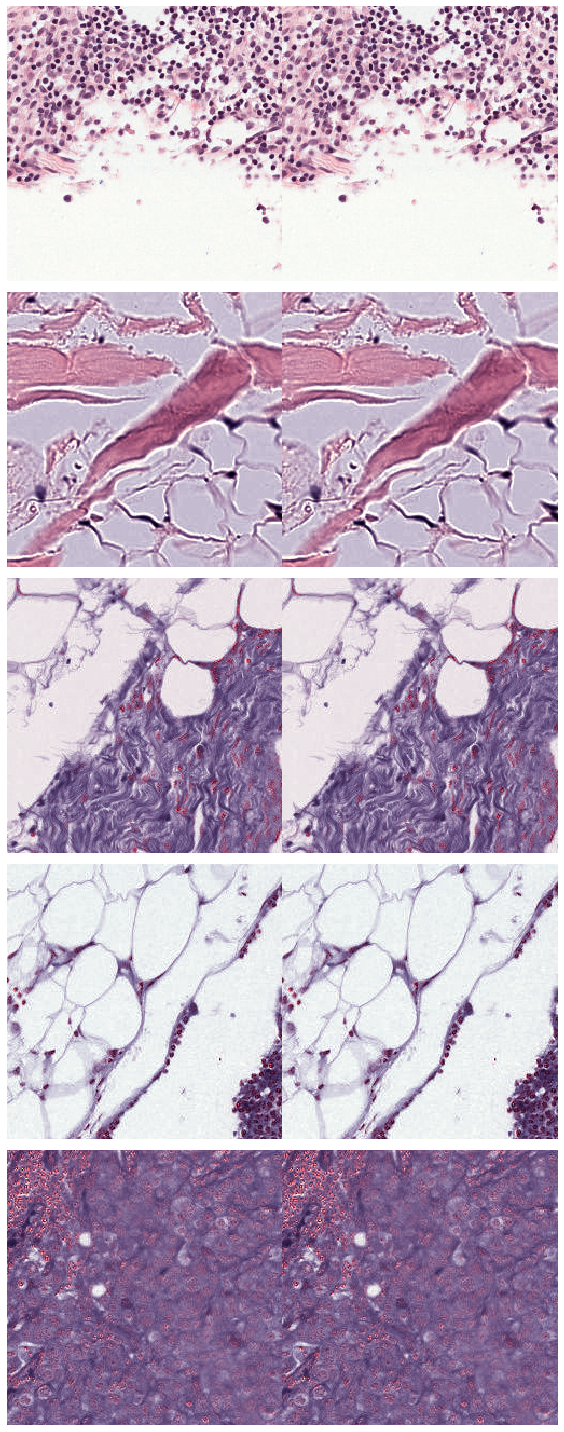

In [160]:
db.show_batch()

## Build encoder

In [8]:
encoder = se_resnext50_32x4d(pretrained=True).cuda()
encoder

Sequential(
  (0): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (1): Sequential(
    (0): SEResNeXtBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (se_module): SEModule(
        (avg_pool): 

In [9]:
# drop   (5): AvgPool2d(kernel_size=7, stride=1, padding=0)
#        (6): Linear(in_features=2048, out_features=1000, bias=True)
encoder = encoder[:5]

In [10]:
t,_ = next(iter(db.dl()))

In [11]:
t.size()

torch.Size([64, 3, 256, 256])

In [12]:
# pipe through network ad check the shape
encoder(t).size()

torch.Size([64, 2048, 8, 8])

In [13]:
# the output size currently is
2048 * 8 * 8

131072

In [14]:
# image size is
256 * 256 * 3

196608

Considering that the task of the autoencoder is to map the image to a different format, and then back to the image. We want to have less parameters in the encoded format. 

In [15]:
code_sz = 64

conv = nn.Conv2d(2048, code_sz, kernel_size=(2,2)).cuda()

encoder.add_module('CodeIn',conv)

In [16]:
encoder(t).size()

torch.Size([64, 64, 7, 7])

## Decoder

In [17]:
class UpSample(nn.Module):
    def __init__(self,feat_in,feat_out,out_shape=None,scale=2):
        super().__init__()
        self.conv = nn.Conv2d(feat_in,feat_out,kernel_size=(3,3),stride=1,padding=1)
        self.out_shape,self.scale = out_shape,scale
        
    
    def forward(self,x):
        return self.conv(
            nn.functional.interpolate(
                x,size=self.out_shape,scale_factor=self.scale,mode='bilinear',align_corners=True))

In [18]:
def get_upSamp(feat_in,feat_out, out_shape=None, scale=2, act='relu'):
    
    upSamp = UpSample(feat_in,feat_out,out_shape=out_shape,scale=scale).cuda()
    
    layer = nn.Sequential(upSamp)
    
    if act == 'relu':
        act_f = nn.ReLU(inplace=True).cuda()
        bn = nn.BatchNorm2d(feat_out).cuda()
        layer.add_module('ReLU',act_f)
        layer.add_module('BN',bn)
    elif act == 'sig':
        act_f = nn.Sigmoid()
        layer.add_module('Sigmoid',act_f)
    return layer

def add_layer(m,feat_in,feat_out,name,out_shape=None,scale=2,act='relu'):
    upSamp = get_upSamp(feat_in,feat_out,out_shape=out_shape,scale=scale,act=act)
    m.add_module(name,upSamp)

Piece up

In [19]:
add_layer(encoder,code_sz,512,'CodeOut',out_shape=(16,16),scale=None)

In [20]:
encoder(t).size()

torch.Size([64, 512, 16, 16])

In [21]:
add_layer(encoder,512,256,'Upsample0')
encoder(t).size()

torch.Size([64, 256, 32, 32])

In [22]:
add_layer(encoder,256,128,'Upsample1')
encoder(t).size()

torch.Size([64, 128, 64, 64])

In [23]:
add_layer(encoder,128,64,'Upsample2')
encoder(t).size()

torch.Size([64, 64, 128, 128])

In [24]:
add_layer(encoder,64,3,'Upsample3',act='sig')
encoder(t).size()

torch.Size([64, 3, 256, 256])

In [25]:
encoder(t).size(), t.size()

(torch.Size([64, 3, 256, 256]), torch.Size([64, 3, 256, 256]))

In [26]:
encoder[5]

Conv2d(2048, 64, kernel_size=(2, 2), stride=(1, 1))

## Learner

In [27]:
learner = Learner(db,encoder,loss_func=F.mse_loss)
learner.split(lambda m: (m[4],m[5]))

Learner(data=ImageDataBunch;

Train: LabelList (107768 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: .;

Valid: LabelList (26942 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (1): Sequential(
    (0): SEResNeXtBottleneck(
      (conv1): Conv2d(64, 128

In [254]:
learner.freeze_to(2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


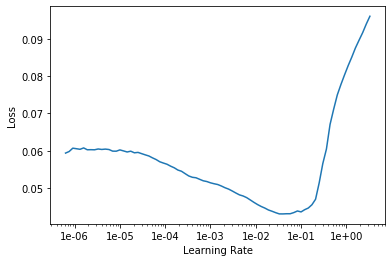

In [257]:
learner.lr_find()
learner.recorder.plot()

In [258]:
learner.fit_one_cycle(10,1e-3)

# Is this learning?

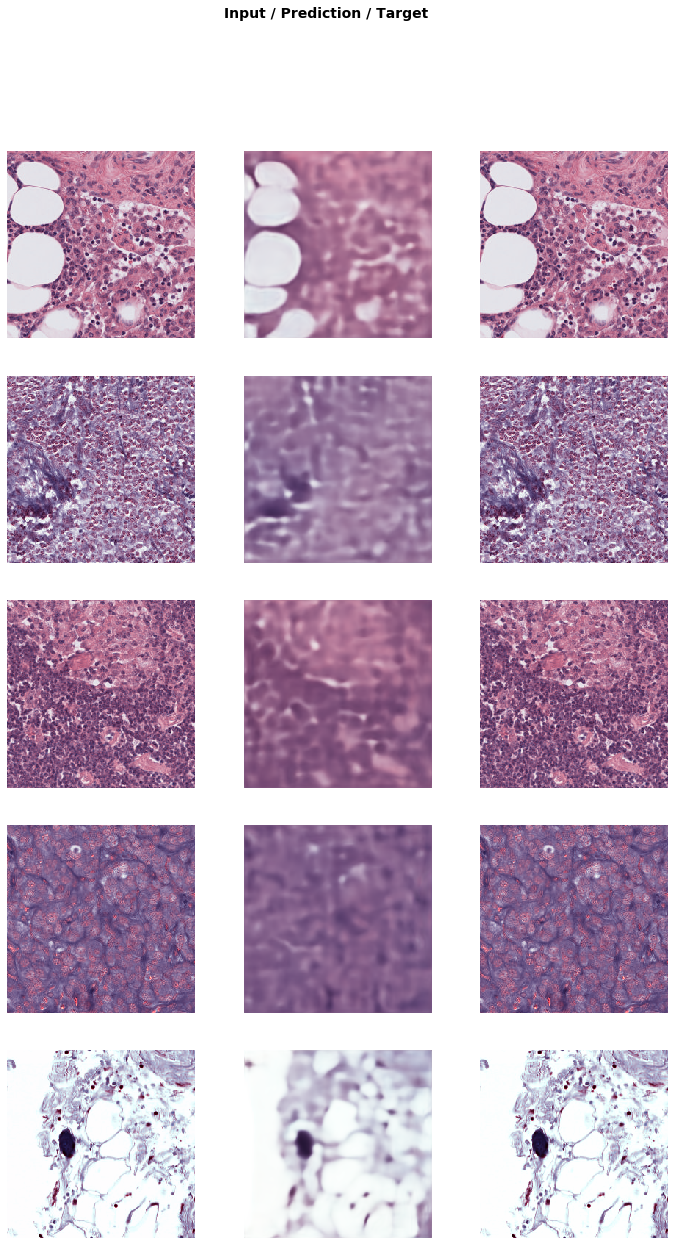

In [259]:
learner.show_results()

In [260]:
learner.save('20190804-Autoencoder_se_resnext50_normalized_lvl2_midphase')

Okay, the whole point of training the autoencoder is to pretrain the weights for a multilevel model. So far, the whole encoder part has been freezed to avoid messing the weights with untrained tail. Now, we can unfreeze the last few blocks of the encoder for pretraining.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


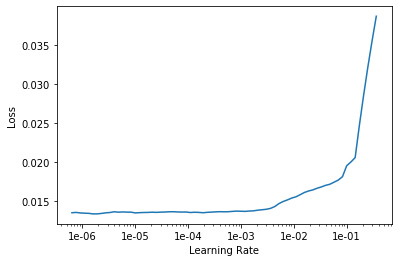

In [261]:
learner.freeze_to(1)
learner.lr_find()
learner.recorder.plot()

In [262]:
learner.fit_one_cycle(8,8e-5)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



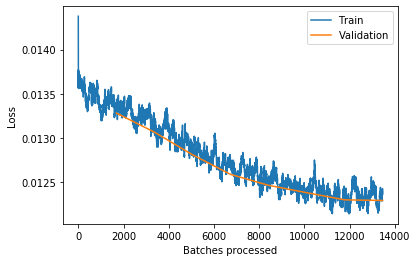

In [265]:
learner.recorder.plot_losses()

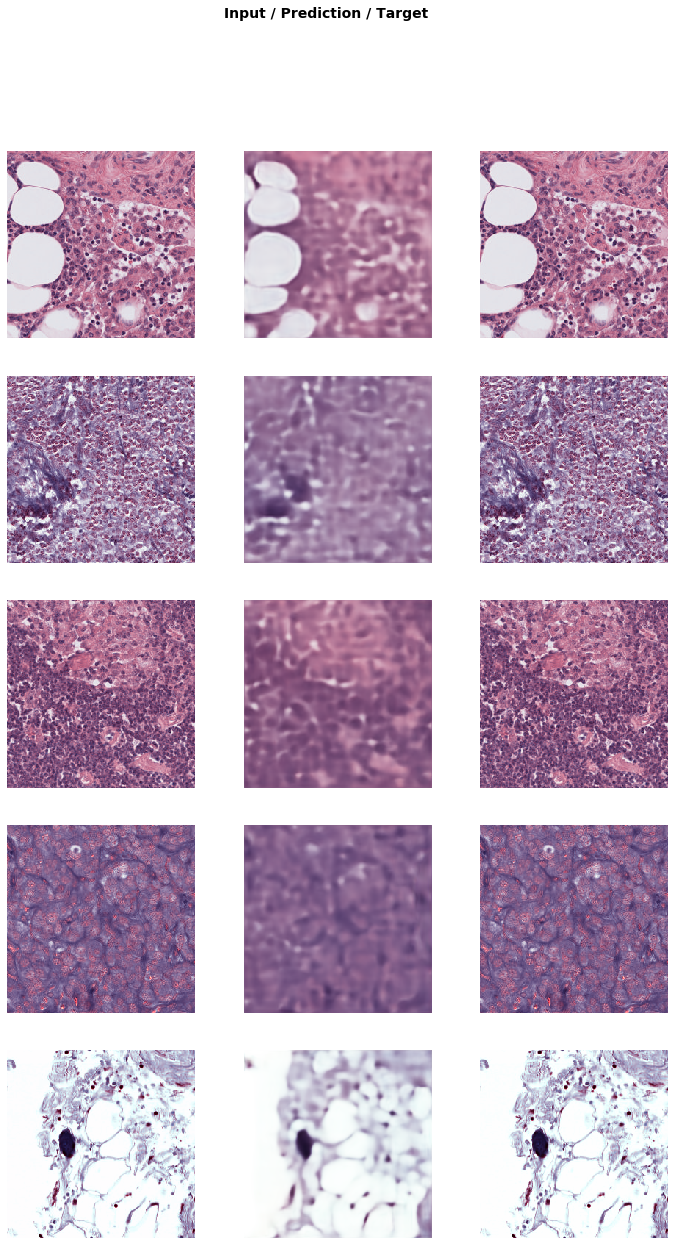

In [263]:
learner.show_results()

In [264]:
learner.save('20190804-Autoencoder_se_resnext50_normalized_lvl2')

In [266]:
# final phase. unfreeze the whole model
learner.unfreeze()

In [267]:
learner.fit_one_cycle(4,1e-5)

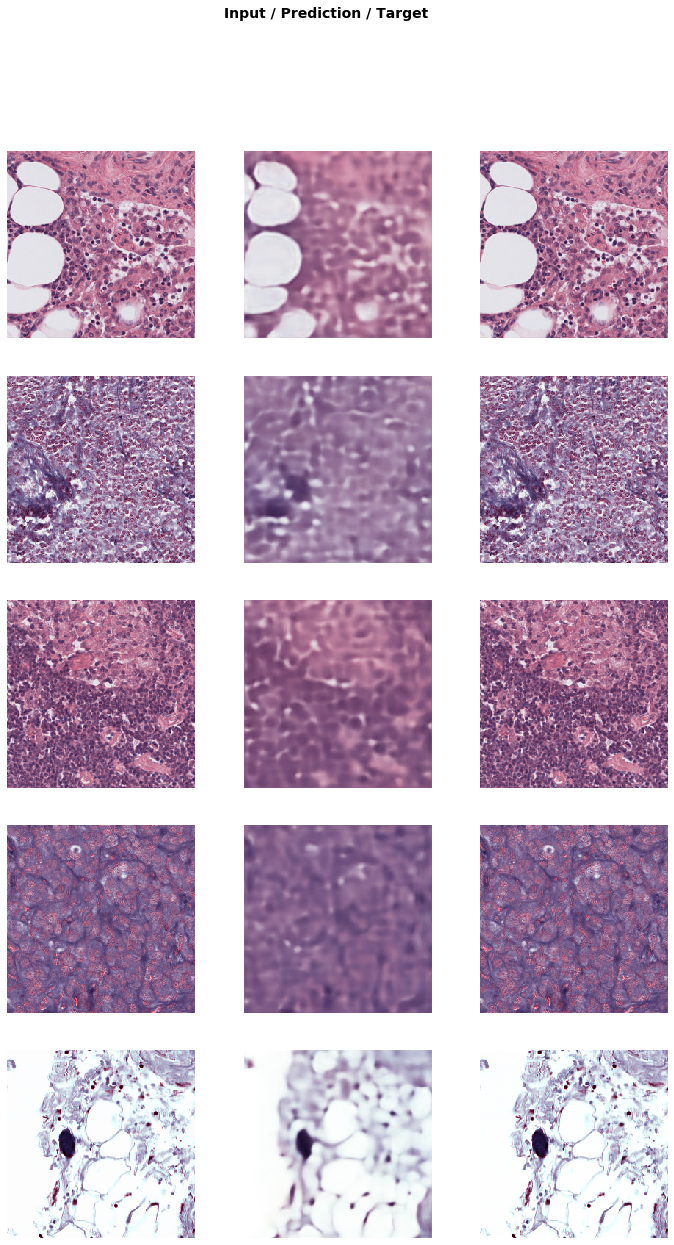

In [268]:
learner.show_results()

In [269]:
learner.save('20190804-Autoencoder_se_resnext50_normalized_lvl2_finetuned')

In [270]:
learner.fit_one_cycle(8,1e-4)

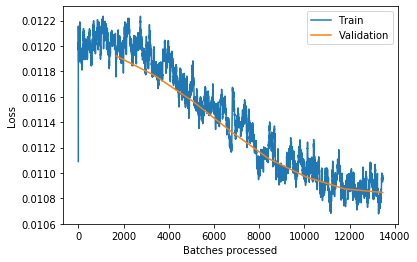

In [273]:
learner.recorder.plot_losses()

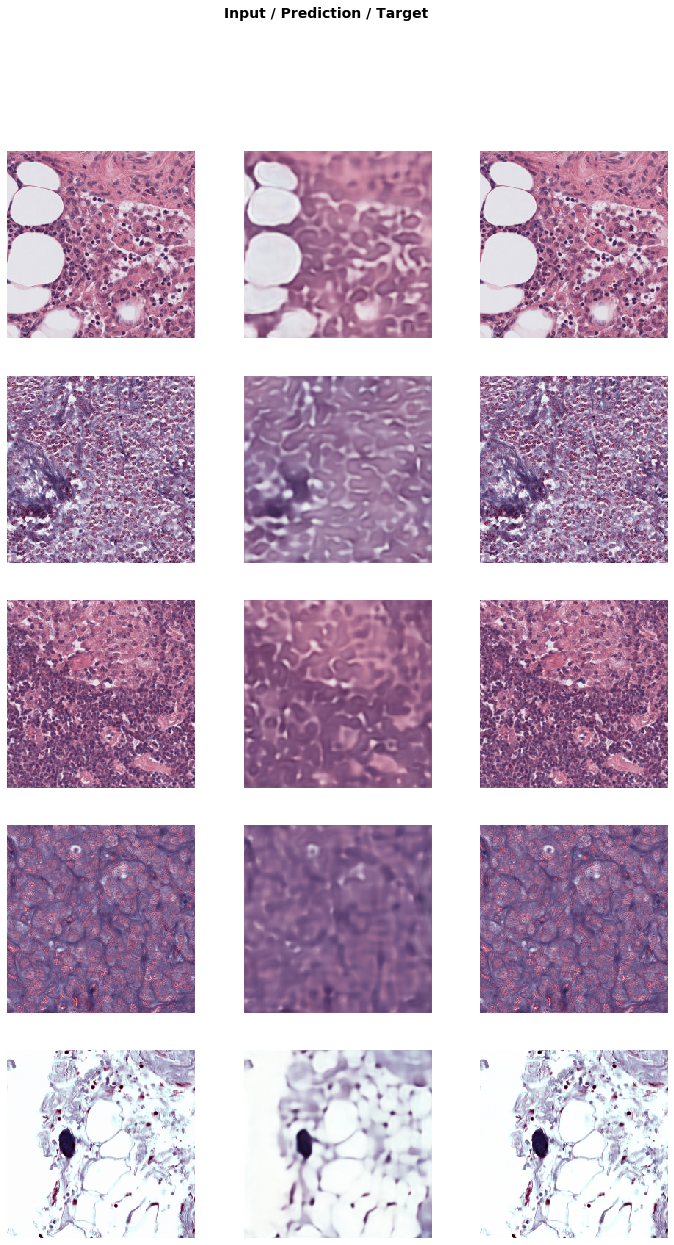

In [271]:
learner.show_results()

In [272]:
learner.save('20190804-Autoencoder_se_resnext50_normalized_lvl2_finetuned2')

In [274]:
learner.fit_one_cycle(8,2e-4)

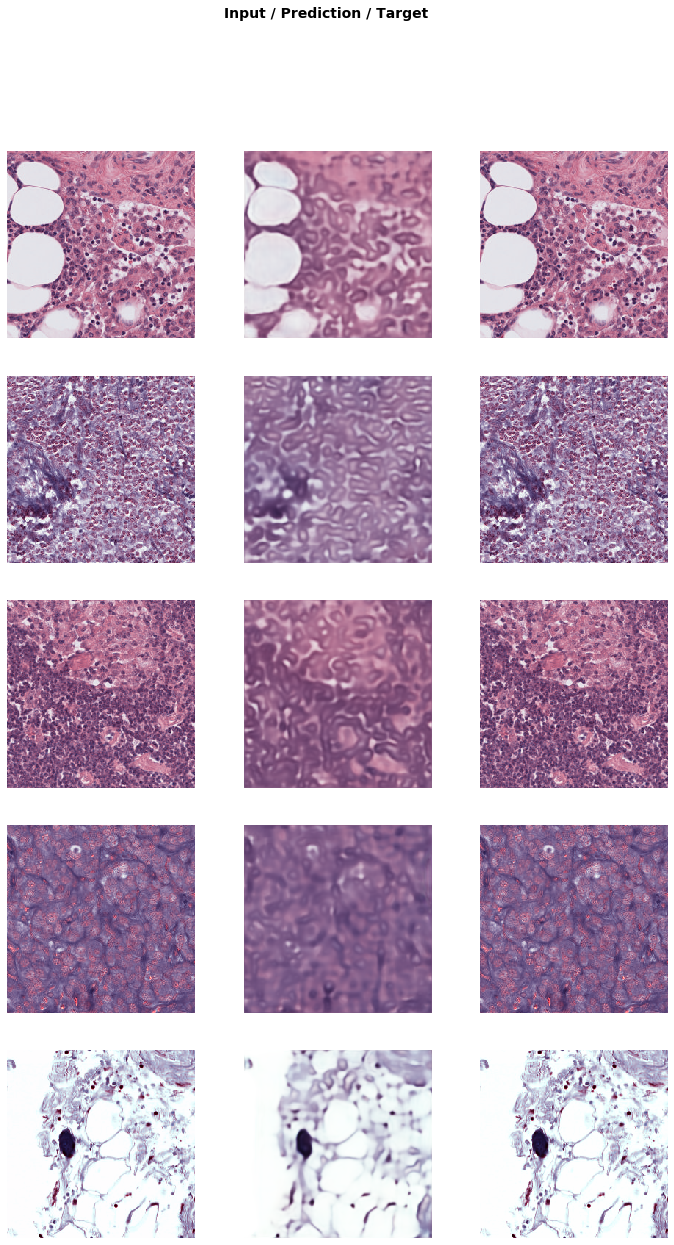

In [275]:
learner.show_results()

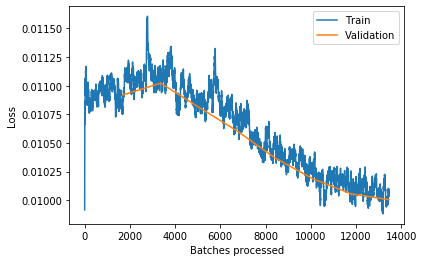

In [276]:
learner.recorder.plot_losses()

In [277]:
learner.save('20190804-Autoencoder_se_resnext50_normalized_lvl2_finetuned3')

In [278]:
learner.fit_one_cycle(8,4e-4)

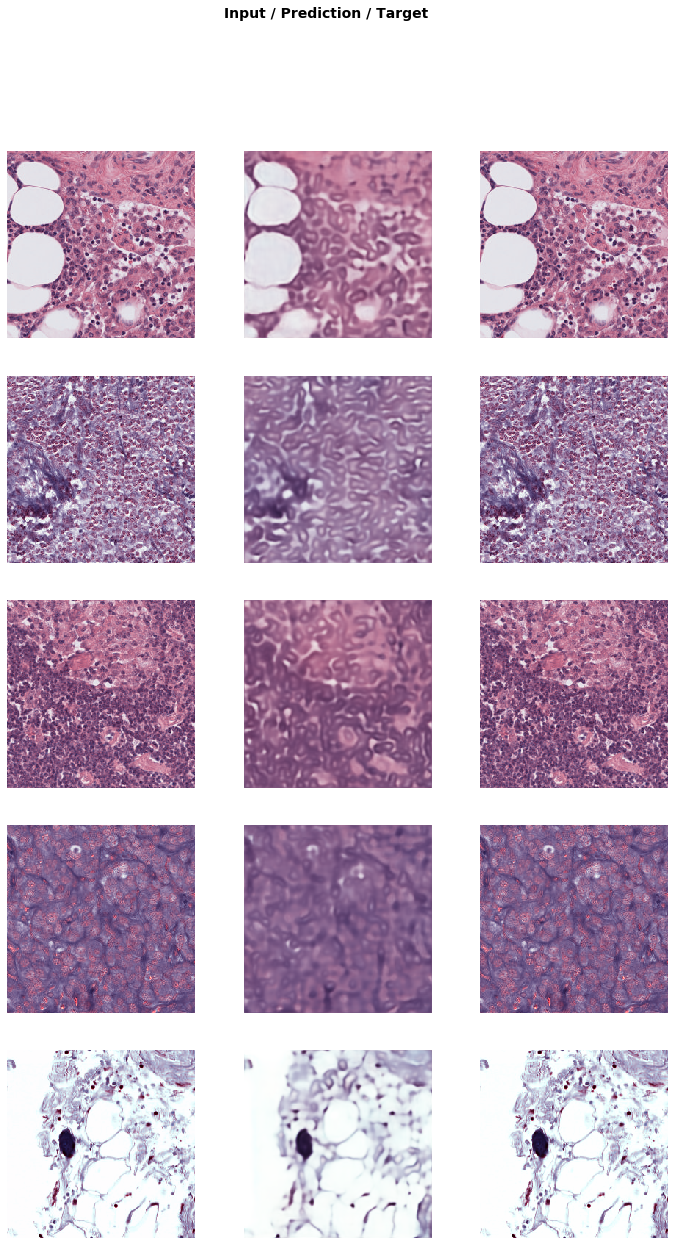

In [279]:
learner.show_results()

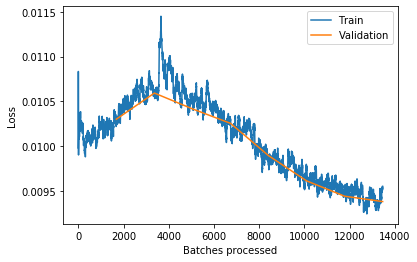

In [280]:
learner.recorder.plot_losses()

In [281]:
learner.save('20190804-Autoencoder_se_resnext50_normalized_lvl2_finetuned4')

## Interpolate

In [42]:
learner.load('20190804-Autoencoder_se_resnext50_normalized_lvl2_finetuned4')

/home/jonijuvonen/.conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type UpSample. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (107768 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: .;

Valid: LabelList (26942 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (1): Sequential(
    (0): SEResNeXtBottleneck(
      (conv1): Conv2d(64, 128

In [298]:
learner.model

Sequential(
  (0): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (1): Sequential(
    (0): SEResNeXtBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (se_module): SEModule(
        (avg_pool): 

In [43]:
decoder0 = learner.model.CodeOut
decoder1 = learner.model.Upsample0
decoder2 = learner.model.Upsample1
decoder3 = learner.model.Upsample2
decoder4 = learner.model.Upsample3

In [44]:
vec = Tensor(size=(1,64,7,7)).float().cuda()
vec.size()

torch.Size([1, 64, 7, 7])

In [45]:
decoder4(decoder3(decoder2(decoder1(decoder0(vec))))).shape

torch.Size([1, 3, 256, 256])

In [46]:
def decode(vector):
    with torch.no_grad():
        im = decoder4(decoder3(decoder2(decoder1(decoder0(vector)))))
        return Image(im[0])

In [47]:
encoder0 = learner.model[:5]
encoder1 = learner.model.CodeIn

In [48]:
def encode(im):
    with torch.no_grad():
        return encoder1(encoder0(im))[0]

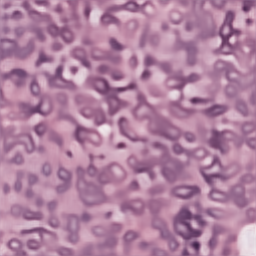

In [86]:
im_1 = encode(t[19].reshape(1,3,256,256)).reshape(1,64,7,7)
decode(im_1)

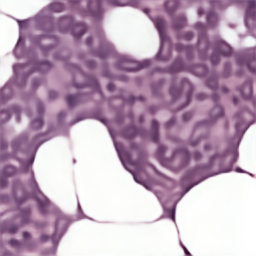

In [50]:
im_2 = encode(t[1].reshape(1,3,256,256)).reshape(1,64,7,7)
decode(im_2)

In [56]:
def interpolate(im1, im2, alpha=0.5):
    im = im1 * alpha + im2 * (1-alpha)
    return decode(im)

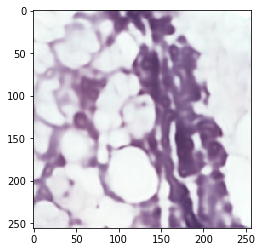

In [70]:
plt.imshow(image2np(interpolate(im_1,im_2,alpha=0.75).data))

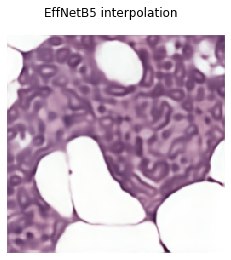

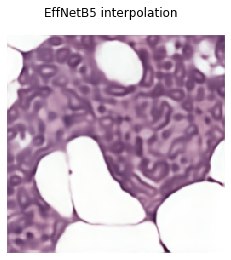

In [87]:
from IPython import display
import time
%matplotlib inline

alpha_int = 0
while(alpha_int < 21):    
        
    plt.clf()
    img = image2np(interpolate(im_2,im_1,alpha=alpha_int/20).data)
    plt.imshow(img)
    plt.suptitle('EffNetB5 interpolation')
    plt.axis('off')
    plt.savefig('img/EffNetB5_interpolation_' + str(alpha_int + 20)+'.png')
    #frame update
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.)
        
    alpha_int += 1

In [39]:
#learner.predict(Image(torch.clamp((t[1]*0.22 + 0.45),0,1).cpu()))[0]

In [ ]:
#[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

In [41]:
#torch.clamp((t[1]*0.22 + 0.45),0,1).max()

In [40]:
#learner.show_results()